<a href="https://colab.research.google.com/github/liannesr/Lab-9-Machine-Learning/blob/master/Lab08_Lianne_Sanchez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 8: Train a Linear Classifier with Numerical and Categorical Features
** Learning Objectives **
* Introduce logistic regression to train a binary classifier.
* Understand metrics such as ROC curves, AUC, log loss, classification errors.
* Train a linear classifier using the raw numerical and categorical features.

### Imports
In this first cell, we import the libraries that we will be using.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
In this lab, you will solve a binary classification problem: Given census data about a person such as age, gender, education and occupation, we will predict whether or not the person earns more than 50,000 dollars a year (the target label). We will train a linear classifier that given the feature values for an individual outputs a number between 0 and 1, which can be interpreted as the probability that the individual has an annual income of over 50K.  Note that if we had the actual income (versus just a Boolean of whether it was over 50,000) then we could learn a regression model to predict income.

The dataset we'll be using is the [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income). We load the [training data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) directly from here. Most of the column names should be self explanatory if not you can read more about it at the website linked above. The number of people the census takers believe that each observation represents (sample weight) could be used to weight the examples during training but for the purpose of this lab you can ignore it.  You don't want to use it as a feature.

In [0]:
import tempfile
import urllib
import urllib.request
train_file = tempfile.NamedTemporaryFile()
urllib.request.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.data", train_file.name)

COLUMNS = ["age", "workclass", "sample_weight", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

census_df = pd.read_csv(train_file, names=COLUMNS, skipinitialspace=True)
# Show the first 5 rows of the table.
census_df.head(5)

,age,workclass,sample_weight,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


###Prepare Features

Here is a basic implementation of `PrepareFeatures` for you to use.  Feel free to modify this to use feature normalization other than just linear scaling.  

Note that for linear classification with just two labels, the labels must be 0 (think of this as false) and 1 (think of this as true).  Since `income_brackets` is a string, we must convert it to an integer. This can be done using a lambda function that outputs a Boolean  value, and then casts it to an integer. We have provided this for you.

In [0]:
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain the data.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  for feature in NUMERICAL_FEATURES:
    processed_features[feature] = linear_scale(dataframe[feature])
    
  # Convert the output target to 0 (for <=50k) and 1 (> 50k)
  processed_features[LABEL] = dataframe["income_bracket"].apply(
      lambda x: ">50K" in x).astype(int)
  
  return processed_features

### Input Function
We'll continue to use this same input function. You do not need to change this but if you want more detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data and Using the Validation Data

We can now use a lambda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data and also on the validation data.

In [0]:
CATEGORICAL_FEATURES = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
NUMERICAL_FEATURES = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES,
LABEL = "income_over_50k"

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

# Here we define an input function that will compute the loss over the entire
# validation set.
predict_validation_input_fn = lambda: input_fn(
    validation_examples[FEATURES], validation_examples[LABEL], 
    num_epochs=1, shuffle=False)

### Functions to Help Visualize Our Results

Since this is a classification problem, the calibration plot is not a good visualization tool. Instead we use an **ROC curve** in which the x-axis is the false positive rate and the y-axis is the true positive rate.  An ROC curve is a very good way to visualize the quality of a binary classifier and also to pick a threshold when making a binary prediction.  Recall that the line `x=y` corresponds to a random classifier.  **AUC** (the area under the ROC curve) has the nice *probabilistic interpretation that a random positive example is predicted to be more likely to be positive than a random negative example*.

Our implementation of `make_roc_curve` uses the [sklearn metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) class. There are a lot of tools already available within Python libraries so be sure and look for those. 

In [0]:
def make_roc_curve(predictions, targets):
  """ Plots an ROC curve for the provided predictions and targets.

  Args:
    predictions: the probability that the example has label 1.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
      targets, predictions)
  
  plt.ylabel("true positive rate")
  plt.xlabel("false positive rate")
  plt.plot(false_positive_rate, true_positive_rate)
  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

### Compute Loss

For classification problems, we generally would like our output to be a probability distribution over the possible classes.  When we have two classes the **log loss** is a measure of how close the predicted distribution is to the target distribution, and that is the metric that we will optimize. Again, we use the [sklearn metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) class. 

In [0]:
def compute_loss(probabilities, targets):
  """ Computes the log loss for training a linear classifier.
  
  Args:
    probabilities: the model predictions as probabilities
    targets: a list of the target values being predicted that must be the
             same length as probabilities.
    
  Returns:
    The log loss for the provided probabilities and targets.
  """      
  return metrics.log_loss(targets, probabilities)

### Train Model

Observe that `define_linear_classifier` is like `define_linear_regressor` and `train_model` is like `train_linear_regressor` with the changes of using the log loss to optimize, and we use the ROC curve to visualize the model quality.  As before we plot a learning curve to see if the model is converging, to help tune the learning rate, and to check if we are overfitting by looking at the loss on the validation data.

In [0]:
def define_linear_classifier(learning_rate):
  """ Defines a linear classifer to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear classifier created with the given parameters.
  """
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_classifier

# Function to train a classifier that a learning curve and ROC curve to help
# evaluate your model.

def train_model(model, training_features, training_labels,
                validation_features, validation_labels, steps, batch_size):
  """Trains a classifier.
  
  Args:
    model: The model to train
    training_features: The input features from the training data
    training_labels: the labels from the training data
    validation_features: The input features from the validation data
    validation_labels: the labels from the validation data
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained model
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn, predict_training_input_fn, and
  # predict_validation_input_fn
  training_input_fn = lambda: input_fn(training_features, training_labels,
                                       batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(training_features,
                                               training_labels,
                                               num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: input_fn(validation_features,
                                                 validation_labels,
                                                 num_epochs=1, shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print ("Training model...")
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Train the classifier for steps_per_period steps
    _ = model.train(input_fn=training_input_fn, steps=steps_per_period)      
    
    # Use the predict method to compute the predictions as probabilities and
    # from that the training loss.
    probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    probabilities = np.array([item['probabilities'] for item in probabilities])
    training_loss = compute_loss(probabilities, training_labels)
    training_losses.append(training_loss) 
    
    # Also compute the validation loss   
    probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    probabilities = np.array([item['probabilities'] for item in probabilities])
    validation_loss = compute_loss(probabilities, validation_labels)
    validation_losses.append(validation_loss) 
    print ("  Training loss, Validation loss after period %02d : %0.3f, %0.3f" % \
      (period, training_loss, validation_loss))
      
  # Now that training is done print the final training and validation loss    
  print("Final Loss (Log Loss) on the training data: %0.3f" % training_loss) 
  print("Final Loss (Log Loss) on the validation data: %0.3f" % validation_loss) 
  
  # Generate a figure with the learning curve on the left and an ROC curve on
  # the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (Loss vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("ROC Curve on Validation Data")
  probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
  probabilities = np.array([item['probabilities'] for item in probabilities])

  # ROC curve uses the probability that the label is 1.
  make_roc_curve(probabilities[:, 1], validation_examples[LABEL])
   
  return model

##Setting up the Features

We will set things up showing you an example of how to set up each of the kind of features you will be using.  Then you can add in additional features.

####Categorical Feauture Columns with known values.

When the values are known you can simply use a line like below.  If you would view the weights, index 0 will be the first key provided, index 1, the next key,.....

```
gender = tf.contrib.layers.sparse_column_with_keys(column_name="gender", keys=["Female", "Male"])
  ```
####Categorical Feature Columns without known values

Since you don't always know the possible values you can instead assign an index to each possible value via hashing where `hash_bucket_size` is the number of hash buckets used.

```
education = tf.contrib.layers.sparse_column_with_hash_bucket("education", hash_bucket_size=100)
```

####Numerical Feature Columns
As we have seen in past labs, we can directly use numerical features as long as appropriate scaling has been applied. The provided implementation of `prepare_features` linearly scales all numerical featuers to fall in [0,1]
```
 age = tf.contrib.layers.real_valued_column("age") 
```

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample of creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)
  
  # Sample of creating a real-valued column that can be used for numeric data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Return the set of all feature columns generated.
  feature_columns=[gender, education, age]
 
  return feature_columns

###Divide Data into Training and Validation Sets

We first randomize the data, and then split it into a ***training set*** and ***validation set***.  There are 16281 examples so let's set aside 4000 for our validation data.  By randomizing the data before splitting it, we help ensure that our validation set is a representative sample.

In [0]:
census_df = census_df.reindex(np.random.permutation(census_df.index))
training_examples = prepare_features(census_df.head(12281))
validation_examples = prepare_features(census_df.tail(4000))

## Exercise  - Train a Linear Classifier (1/2 point)

Let's start by just training the model with the three features already set-up in `construct_feature_columns`. Without changing anything but the learning_rate and number of steps to train, train the best model you can.

You can get a variety of evaluation metrics on the validation data to help you understand the quality of the models you have trained.  As we mentioned above,  **AUC** (the area under the ROC curve) has the nice *probabilistic interpretation that a random positive example is predicted to be more likely to be positive than a random negative example*.  The accuracy is the fraction of examples (in the provided data set) for which the predicted value is the same as the target label when a threshold of 0.5 on the output (the probability that the example is positive) is used as a threshold for classifying an example as positive or negative.  Finally the loss is the log loss (which is the metric being optimized).

Training model...
  Training loss, Validation loss after period 00 : 0.654, 0.655
  Training loss, Validation loss after period 01 : 0.620, 0.623
  Training loss, Validation loss after period 02 : 0.594, 0.597
  Training loss, Validation loss after period 03 : 0.573, 0.578
  Training loss, Validation loss after period 04 : 0.557, 0.563
  Training loss, Validation loss after period 05 : 0.551, 0.557
  Training loss, Validation loss after period 06 : 0.539, 0.546
  Training loss, Validation loss after period 07 : 0.534, 0.540
  Training loss, Validation loss after period 08 : 0.527, 0.535
  Training loss, Validation loss after period 09 : 0.527, 0.536
Final Loss (Log Loss) on the training data: 0.527
Final Loss (Log Loss) on the validation data: 0.536


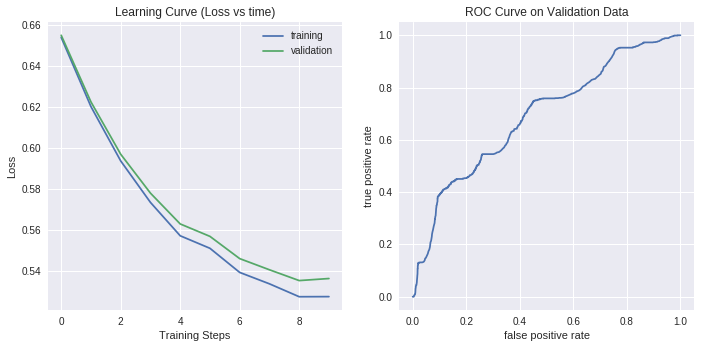

In [0]:
CATEGORICAL_FEATURES = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
NUMERICAL_FEATURES = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES
LABEL = "income_over_50k"

LEARNING_RATE = 0.025
STEPS = 10
BATCH_SIZE = 50

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(
    linear_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=predict_validation_input_fn)

print ("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print ("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print ("Loss on the validation set: %0.2f" % evaluation_metrics['loss'])

AUC on the validation set: 0.70
Accuracy on the validation set: 0.75
Loss on the validation set: 0.54


## Exercise - Train a Better Linear Classifier (4 points)

Using your choice of categorical and numerical features and hyperparameters, train the best linear classifier you can.

For your convenience we have duplicated the definition of `construct_feature_columns` and included it below with the code to train the model. **So far no changes have been made -- that's what you need to do here.**

Feel free to duplicate the code box below if you want to see the results of several different options at once.

**WARNING: As discussed in the slides, regularization is very important for logistic regression. Recall the asymptotes of log loss function (with the slope going to infinity as you approach 0 and 1). Two strategies to avoid overflow are L2 regularization that penalizes huge weights and early stopping that stops the training before overfitting begins.  If you see an error indicating that you divided by zero or a loss of NaN, then most likely this situation has occured. The way to address this problem is to introduce regularization (which you will learn how to do in the next lab). For now, the solution is to reduce the learning rate and/or the number of training steps even if that means that your model is undertrained.**

Training model...
  Training loss, Validation loss after period 00 : 0.618, 0.621
  Training loss, Validation loss after period 01 : 0.573, 0.577
  Training loss, Validation loss after period 02 : 0.542, 0.548
  Training loss, Validation loss after period 03 : 0.525, 0.533
  Training loss, Validation loss after period 04 : 0.512, 0.520
  Training loss, Validation loss after period 05 : 0.506, 0.514
  Training loss, Validation loss after period 06 : 0.501, 0.509
  Training loss, Validation loss after period 07 : 0.497, 0.506
  Training loss, Validation loss after period 08 : 0.491, 0.500
  Training loss, Validation loss after period 09 : 0.488, 0.496
Final Loss (Log Loss) on the training data: 0.488
Final Loss (Log Loss) on the validation data: 0.496


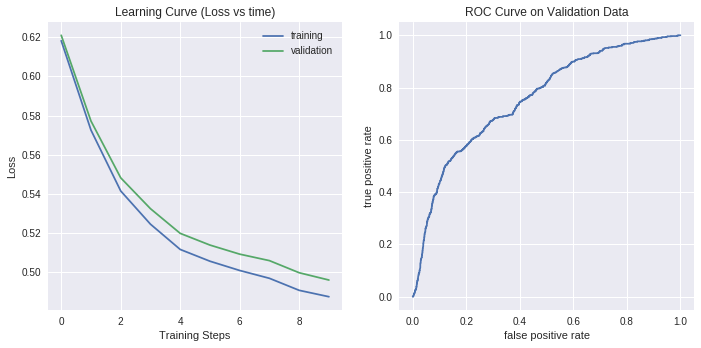

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample of creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)
  
  # Sample of creating a real-valued column that can be used for numerical data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Sample of creating a real-valued column that can be used for numerical data.
  hours_per_week = tf.contrib.layers.real_valued_column("hours_per_week")

  # Sample of creating a categorical column with a hash bucket
  occupation = tf.contrib.layers.sparse_column_with_hash_bucket("occupation", hash_bucket_size=50)

  # Return the set of all feature columns generated.
  feature_columns=[gender, education, age, occupation, hours_per_week]
 
  return feature_columns

# Defining and training a model

CATEGORICAL_FEATURES = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
NUMERICAL_FEATURES = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES
LABEL = "income_over_50k"

LEARNING_RATE = 0.015
STEPS = 50
BATCH_SIZE = 50

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(
    linear_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

Let's look at the evaluation metrics for your trained model.

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=predict_validation_input_fn)

print ("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print ("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print ("Loss on the validation set: %0.2f" % evaluation_metrics['loss'])

AUC on the validation set: 0.76
Accuracy on the validation set: 0.75
Loss on the validation set: 0.50


Training model...
  Training loss, Validation loss after period 00 : 0.566, 0.570
  Training loss, Validation loss after period 01 : 0.517, 0.523
  Training loss, Validation loss after period 02 : 0.494, 0.500
  Training loss, Validation loss after period 03 : 0.468, 0.474
  Training loss, Validation loss after period 04 : 0.450, 0.455
  Training loss, Validation loss after period 05 : 0.443, 0.448
  Training loss, Validation loss after period 06 : 0.438, 0.445
  Training loss, Validation loss after period 07 : 0.430, 0.432
  Training loss, Validation loss after period 08 : 0.425, 0.427
  Training loss, Validation loss after period 09 : 0.434, 0.433
Final Loss (Log Loss) on the training data: 0.434
Final Loss (Log Loss) on the validation data: 0.433


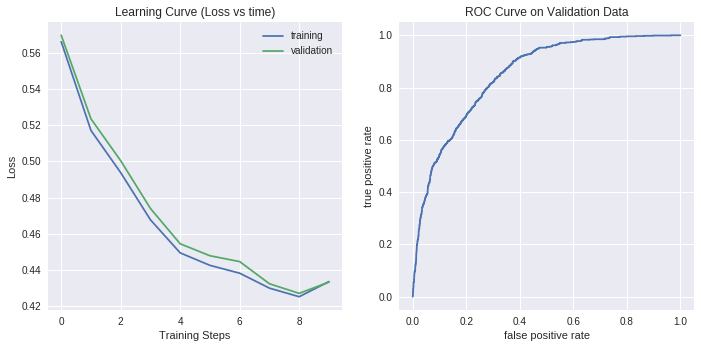

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample of creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)

# Sample of creating a categorical columns with a hash bucket.    
  workclass = tf.contrib.layers.sparse_column_with_hash_bucket(
      "workclass", hash_bucket_size=50)
  
  # Sample of creating a categorical columns with a hash bucket.    
  marital_status = tf.contrib.layers.sparse_column_with_hash_bucket(
      "marital_status", hash_bucket_size=50)

  # Sample of creating a real-valued column that can be used for numerical data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Sample of creating a real-valued column that can be used for numerical data.
  hours_per_week = tf.contrib.layers.real_valued_column("hours_per_week")

  # Sample of creating a real-valued column that can be used for numerical data.
  education_num = tf.contrib.layers.real_valued_column("education_num")

  # Sample of creating a categorical column with a hash bucket
  occupation = tf.contrib.layers.sparse_column_with_hash_bucket("occupation", hash_bucket_size=50)

  # Return the set of all feature columns generated.
  feature_columns=[gender, education, age, occupation, hours_per_week, education_num, workclass, marital_status]
 
  return feature_columns

# Defining and training a model

CATEGORICAL_FEATURES = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
NUMERICAL_FEATURES = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES
LABEL = "income_over_50k"

LEARNING_RATE = 0.04
STEPS = 20
BATCH_SIZE = 50

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(
    linear_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=predict_validation_input_fn)

print ("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print ("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print ("Loss on the validation set: %0.2f" % evaluation_metrics['loss'])

AUC on the validation set: 0.85
Accuracy on the validation set: 0.78
Loss on the validation set: 0.43


Training model...
  Training loss, Validation loss after period 00 : 0.515, 0.519
  Training loss, Validation loss after period 01 : 0.460, 0.465
  Training loss, Validation loss after period 02 : 0.434, 0.438
  Training loss, Validation loss after period 03 : 0.419, 0.424
  Training loss, Validation loss after period 04 : 0.407, 0.411
  Training loss, Validation loss after period 05 : 0.401, 0.407
  Training loss, Validation loss after period 06 : 0.399, 0.405
  Training loss, Validation loss after period 07 : 0.398, 0.405
  Training loss, Validation loss after period 08 : 0.398, 0.401
  Training loss, Validation loss after period 09 : 0.390, 0.394
Final Loss (Log Loss) on the training data: 0.390
Final Loss (Log Loss) on the validation data: 0.394


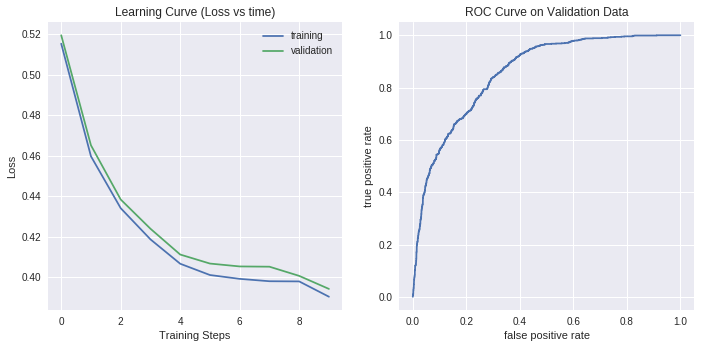

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features
  
  Returns:
    A set of feature columns.
  """
  
  # Sample of creating a categorical column with known values.
  gender = tf.contrib.layers.sparse_column_with_keys(
    column_name="gender", keys=["Female", "Male"])
  
  # Sample of creating a categorical columns with a hash bucket.    
  education = tf.contrib.layers.sparse_column_with_hash_bucket(
      "education", hash_bucket_size=50)

# Sample of creating a categorical columns with a hash bucket.    
  workclass = tf.contrib.layers.sparse_column_with_hash_bucket(
      "workclass", hash_bucket_size=50)
  
  # Sample of creating a categorical columns with a hash bucket.    
  marital_status = tf.contrib.layers.sparse_column_with_hash_bucket(
      "marital_status", hash_bucket_size=50)

  # Sample of creating a categorical columns with a hash bucket.    
  relationship = tf.contrib.layers.sparse_column_with_hash_bucket(
      "relationship", hash_bucket_size=50)

  # Sample of creating a categorical columns with a hash bucket.    
  race = tf.contrib.layers.sparse_column_with_hash_bucket(
      "race", hash_bucket_size=50)

  # Sample of creating a categorical columns with a hash bucket.    
  native_country = tf.contrib.layers.sparse_column_with_hash_bucket(
      "native_country", hash_bucket_size=50)

  # Sample of creating a real-valued column that can be used for numerical data.
  age = tf.contrib.layers.real_valued_column("age") 

  # Sample of creating a real-valued column that can be used for numerical data.
  hours_per_week = tf.contrib.layers.real_valued_column("hours_per_week")

  # Sample of creating a real-valued column that can be used for numerical data.
  education_num = tf.contrib.layers.real_valued_column("education_num")

  # Sample of creating a real-valued column that can be used for numerical data.
  capital_gain = tf.contrib.layers.real_valued_column("capital_gain")

  # Sample of creating a real-valued column that can be used for numerical data.
  capital_loss = tf.contrib.layers.real_valued_column("capital_loss")

  # Sample of creating a categorical column with a hash bucket
  occupation = tf.contrib.layers.sparse_column_with_hash_bucket("occupation", hash_bucket_size=50)

  # Return the set of all feature columns generated.
  feature_columns=[gender, education, age, occupation, hours_per_week, education_num, workclass, marital_status,relationship,race, native_country]
 
  return feature_columns

# Defining and training a model

CATEGORICAL_FEATURES = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
NUMERICAL_FEATURES = ["age", "education_num", "capital_gain", "capital_loss",
                      "hours_per_week"]
FEATURES = NUMERICAL_FEATURES+CATEGORICAL_FEATURES
LABEL = "income_over_50k"

LEARNING_RATE = 0.015
STEPS = 100
BATCH_SIZE = 50

linear_classifier = define_linear_classifier(learning_rate = LEARNING_RATE)
linear_classifier = train_model(
    linear_classifier, training_examples[FEATURES],
    training_examples[LABEL], validation_examples[FEATURES],
    validation_examples[LABEL], batch_size=BATCH_SIZE, steps=STEPS)

In [0]:
evaluation_metrics = linear_classifier.evaluate(
 input_fn=predict_validation_input_fn)

print ("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print ("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])
print ("Loss on the validation set: %0.2f" % evaluation_metrics['loss'])

AUC on the validation set: 0.86
Accuracy on the validation set: 0.82
Loss on the validation set: 0.39


## Exercise - Look at Evaluation Metrics on the Test Data (1/2 point)

Like with the housing data, this data set has a specified [test data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test) that we can use at the end to look at the performance for our final classifier.  We will load it and do the pre-processing here but this should not be used in training or selecting any of the hyperparameters.

In the first code box below put and execute code to compute the accuracy and AUC of your model on the test data.  Then in your own words interpret what these numbers are telling you about how your model will perform.


In [0]:
# Finish this code box to compute accuracy and AUC on the test input. Use what is done for the validation data to guide you.

test_file = tempfile.NamedTemporaryFile()
urllib.request.urlretrieve("http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/adult.test", test_file.name)

census_df_test = pd.read_csv(test_file, names=COLUMNS, skipinitialspace=True, skiprows=1)
test_examples = prepare_features(census_df_test)

# using the code above to guide you if needed define a test_input_fn and

features = test_examples[NUMERICAL_FEATURES+CATEGORICAL_FEATURES]
targets = test_examples[LABEL]
test_input_fn = lambda: input_fn(features, targets, num_epochs=1,
                                         shuffle=False)
# Fill in the rest to complete this.
evaluation_metrics = linear_classifier.evaluate(
 input_fn=test_input_fn)

print ("AUC on the test set: %0.2f" % evaluation_metrics['auc'])
print ("Accuracy on the test set: %0.2f" % evaluation_metrics['accuracy'])
print ("Loss on the test set: %0.2f" % evaluation_metrics['loss'])

AUC on the test set: 0.86
Accuracy on the test set: 0.83
Loss on the test set: 0.39


In [0]:
"""
Explain in your own words what the accuracy and AUC values are saying about how your model will perform.

1. Accuracy: The accuracy means the quantity of predictions that were correct in our data set.
This means, that with the evaluation metrics that our classifier predicts the correct answer
83% of the time. A threshold is used for classifyinf an example as positive or negative.
 This is not a very reliable metric because it depends only on the data,
and we could have a model that is not necessarily correct.

2. Area under the curve (AUC): Area under the curve is the ratio between TP vs. FP rates.
It shows and measures how good is the classifier. When it says that AUC is .86 which 
is much better than a classifier that has .5 which means that it doesn't have any diagnostic ability.
By having 0.86 which is a lot closer to 0, we have the ability to choose a random positive value 
and have more probability of predicting a positive value (which is correct), than a negative one.  
The ideal model is to have AUC 1, where FN=0 and FP = 0; 

"""